In [72]:
import numpy as np

# 基本参数
SimParam = {
    "Area_Lim": [0, 2.4, 0, 2.4],  # 仿真区域范围，x和y轴都是0到6m
    "Step_Size": 0.05,  # 划分步长，隔0.05m划分（即x和y都是 0:0.05:6）
    "T_Intervel_Sim": 0.1,  # 仿真时间间隔 0.1秒
    "T_Intervel_Act": 0.05,  # 实际时间间隔 0.05秒
    "Sound_v": 340,  # 声速 340m/s
    "Sampling_fs": 48000,  # 麦克风采样率 48 KHz
    "Sim_Size": 20000,  # 仿真的样本条数
    "Data_Length": 120,  # 每条样本的长度（时间步、样点数）
}

# WiFi设备参数
WifiParam = {
    "Dev_tx": [0, 0],  # tx表示transmitter，发射机坐标
    "Dev_rx": [2.4, 0],  # rx表示receiver，三个接收机坐标
    "AntennaNum": 3,  # WiFi天线数量
    "SubCarrierNum": 30,  # WiFi子载波数量
    "SampleRate": 1000,  # WiFi采样率
    "Carrier_Freq": 5320e6,  # Wifi信道频率（5.32GHz）
    "C_Speed": 299792458  # WiFi信号传播速度（电磁波速度=光速，3e8 m/s）
}
WifiParam["Dev_rx"] = WifiParam["Dev_rx"]  # 所选用的接收机坐标
WifiParam["Carrier_Lamda"] = WifiParam["C_Speed"] / WifiParam["Carrier_Freq"]  # 波长


In [73]:
# 预定义训练样本集和标签集
Data_Length = SimParam["Data_Length"]
Sim_Size = SimParam["Sim_Size"]
Area_Lim = SimParam["Area_Lim"]

# 感知区域
x_range = np.arange(SimParam["Area_Lim"][0], SimParam["Area_Lim"][1] + SimParam["Step_Size"], SimParam["Step_Size"])
y_range = np.arange(SimParam["Area_Lim"][2], SimParam["Area_Lim"][3] + SimParam["Step_Size"], SimParam["Step_Size"])
x_range = Area_Lim[0:2]
y_range = Area_Lim[2:4]


# 初始化数据集
training_dataset = np.zeros((Data_Length, 4, Sim_Size))  # 预定义加载空矩阵，节省计算时间
label_dataset = np.zeros((Data_Length, 2, Sim_Size))  # 预定义标签集

# 准备训练数据
print('***** Prepare to generate training dataset *****')
for SimNum in range(Sim_Size):
    pos_init = np.random.rand(2) * (np.array(SimParam["Area_Lim"][1::2]) - np.array(SimParam["Area_Lim"][0::2]))  # 仿真轨迹的初始位置，在区域范围内的随机位置
    v_act = np.zeros((Data_Length, 2))  # 仿真速度，初始x和y的速度都为0
    for sim_a in range(1, Data_Length - 5):
        
        a_speed = np.random.rand(1, 2) * 2 - 0.75    
        v_act[sim_a] = v_act[sim_a - 1] + a_speed * SimParam["T_Intervel_Sim"]  # 仿真速度

        pos_seq = pos_init + np.cumsum(v_act[:sim_a + 1] * SimParam["T_Intervel_Sim"], axis=0)  # 仿真轨迹中的每个坐标

        if min(pos_seq[:, 0]) < min(x_range) or max(pos_seq[:, 0]) > max(x_range) or min(pos_seq[:, 1]) < min(y_range) or max(pos_seq[:, 1]) > max(y_range):
            # 如果轨迹超出范围，将当前轨迹的最后一个有效点作为当前位置
            v_act[sim_a] = 0

    v_act[Data_Length - 5: Data_Length] = 0  # 最后五个时间步速度为0
    v_act_abs = np.linalg.norm(v_act, axis=1)  # 实际速度为x和y速度合并，用的是平方和开根号
    v_act[v_act_abs > 2] = v_act[np.argmax(v_act_abs > 2) - 1]  # 如有，则该时刻速度替换为前一刻的速度（为了避免超出最大值）
    pos_seq = pos_init + np.cumsum(v_act * SimParam["T_Intervel_Sim"], axis=0)  # 仿真轨迹中的每个坐标

    label_dataset[:, :2, SimNum] = pos_seq

    # 计算 Acouplcr
    dist_acou = np.linalg.norm(WifiParam["Dev_tx"] - pos_seq[:, np.newaxis, :], axis=2)
    Acouplcr = np.vstack([np.diff(dist_acou, axis=0) / SimParam["T_Intervel_Sim"], np.zeros((1, 1))])

    # 计算 Wifiplcr
    dist_wifi = np.linalg.norm(WifiParam["Dev_tx"] - pos_seq[:, np.newaxis, :], axis=2) + \
                np.linalg.norm(pos_seq[:, np.newaxis, :] - WifiParam["Dev_rx"], axis=2)
    # print(v_act)
    Wifiplcr = np.vstack([np.diff(dist_wifi, axis=0) / SimParam["T_Intervel_Sim"], np.zeros((1, 1))])

    training_dataset[:, 0, SimNum] = Acouplcr[:, 0]
    training_dataset[:, 1, SimNum] = Wifiplcr[:, 0]
    training_dataset[:, 2:, SimNum] = pos_init

    if (SimNum + 1) % (Sim_Size / 10) == 0:
        print(f"- Generate {SimNum + 1} in {Sim_Size} ({((SimNum + 1) / Sim_Size) * 100:.0f}%) Training Data")


training_data = training_dataset  # 将 Acouplcr 和 Wifiplcr 与初始位置拼在一起，组成训练样本集
label_data = label_dataset  # 轨迹标签集

# 保存生成的数据
np.save('training_data.npy', training_data)
np.save('label_data.npy', label_data)

***** Prepare to generate training dataset *****
- Generate 2000 in 20000 (10%) Training Data
- Generate 4000 in 20000 (20%) Training Data
- Generate 6000 in 20000 (30%) Training Data
- Generate 8000 in 20000 (40%) Training Data
- Generate 10000 in 20000 (50%) Training Data
- Generate 12000 in 20000 (60%) Training Data
- Generate 14000 in 20000 (70%) Training Data
- Generate 16000 in 20000 (80%) Training Data
- Generate 18000 in 20000 (90%) Training Data
- Generate 20000 in 20000 (100%) Training Data


In [74]:
np.save('training_data.npy', training_data)
np.save('label_data.npy', label_data)

print("Training data and label data have been saved to 'training_data.npy' and 'label_data.npy'.")

Training data and label data have been saved to 'training_data.npy' and 'label_data.npy'.


In [75]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed

# 假设 training_data 和 label_data 已经生成

# Reshape the data for LSTM model
input_shape = training_data.shape

# print(training_data[:,:, 1010])
# X = training_data.reshape((input_shape[2], input_shape[0], input_shape[1]))  # (samples, timesteps, features)
# y = label_data.reshape((input_shape[2], input_shape[0], 2))  # (samples, timesteps, 2)
X = training_data.transpose(2, 0, 1)
y = label_data.transpose(2, 0, 1)
# Split data into training and testing sets
split_ratio = 0.8
split_index = int(X.shape[0] * split_ratio)
real_train, X_train, X_test = X[:5], X[5:split_index], X[split_index:]
real_test, y_train, y_test = y[:5], y[5:split_index], y[split_index:]

In [76]:
# Define the model
from tensorflow.keras.callbacks import ModelCheckpoint

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(input_shape[0], input_shape[1]), return_sequences=True))
model.add(TimeDistributed(Dense(2)))  # 输出形状 (时间步, 输出数)   

model.compile(optimizer='adam', loss='mse')

checkpoint = ModelCheckpoint(
    filepath='./saved_models/model_checkpoint_epoch_{epoch:02d}_loss_{val_loss:.2f}.keras',
    monitor='val_loss',  # 监控验证集上的损失
    verbose=1,           # 每次保存模型时，打印相关信息
    save_best_only=True, # 仅保存验证集上表现最好的模型
    mode='min'           # 如果监控值减小，则认为模型性能提高
)

# 训练模型，并使用 ModelCheckpoint 回调函数
model.fit(
    X_train, y_train,
    epochs=200,
    verbose=1,
    validation_data=(X_test, y_test),
    callbacks=[checkpoint]  # 添加回调函数到训练中
)

# 评估模型
loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss}")

Epoch 1/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1.1866
Epoch 1: val_loss improved from inf to 0.24460, saving model to ./saved_models/model_checkpoint_epoch_01_loss_0.24.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 23s 40ms/step - loss: 1.1852 - val_loss: 0.2446
Epoch 2/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1573
Epoch 2: val_loss improved from 0.24460 to 0.08876, saving model to ./saved_models/model_checkpoint_epoch_02_loss_0.09.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - loss: 0.1573 - val_loss: 0.0888
Epoch 3/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0794
Epoch 3: val_loss improved from 0.08876 to 0.05977, saving model to ./saved_models/model_checkpoint_epoch_03_loss_0.06.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - loss: 0.0794 - val_loss: 0.0598
Epoch 4/200
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0555
Epoch 4: val_loss improved from 0.05977 to 0.03984, saving model to ./saved_models/model_checkpoint_epoch_04_loss_0.04.ker

(5, 20, 4)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
(5, 20, 4)


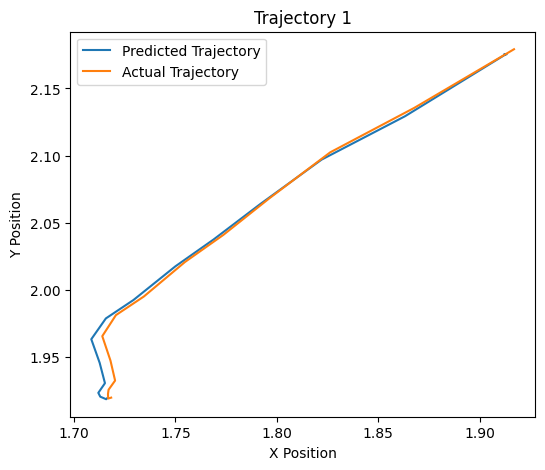

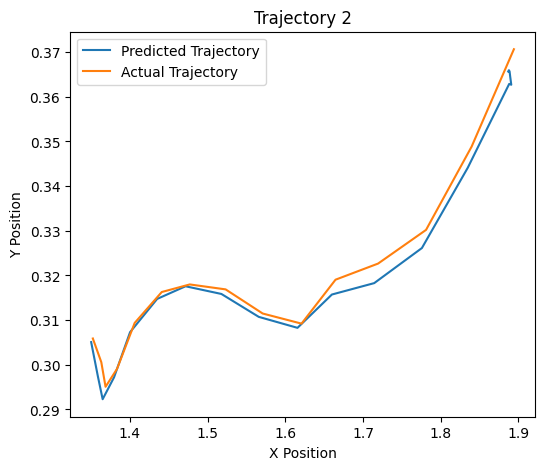

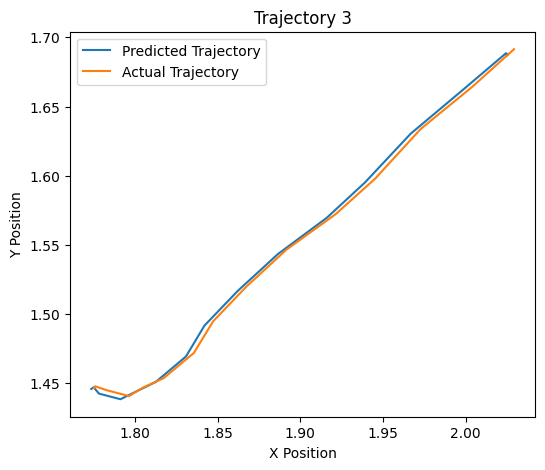

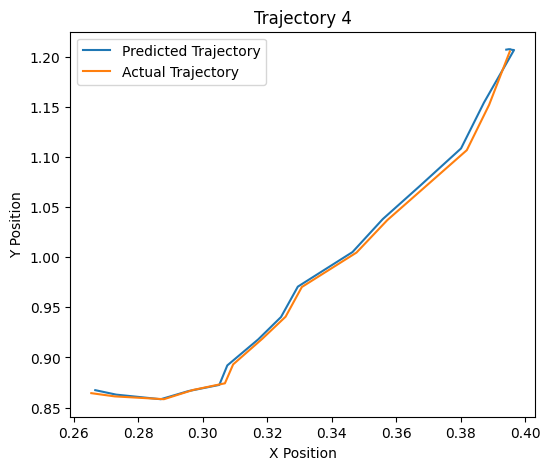

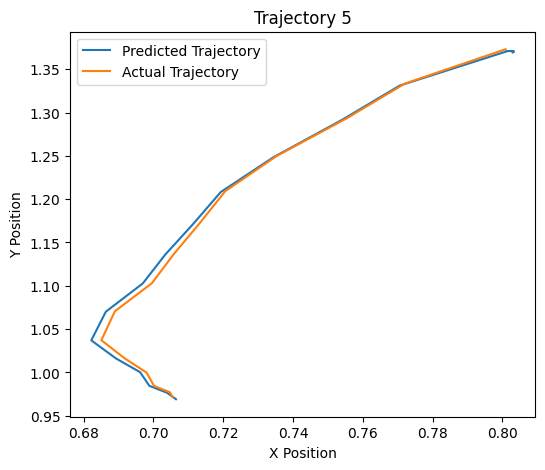

In [ ]:
# Make predictions
print(real_train.shape)
y_pred = model.predict(real_train)

# Optionally, visualize the results
import matplotlib.pyplot as plt
# start = 5
print(real_train.shape)
for i in range(real_train.shape[0]):  # Plot the first 5 trajectories
    plt.figure(figsize=(6, 5))
    plt.plot(y_pred[i, :, 0], y_pred[i, :, 1], label='Predicted Trajectory')
    plt.plot(real_test[i, :, 0], real_test[i, :, 1], label='Actual Trajectory')
    # print(X_test[i, :, 2], X_test[i, :, 3])
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title(f'Trajectory {i+1}')
    plt.legend()
    plt.show()

In [ ]:
model.save('model1.keras')
